In [82]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

In [83]:
# Open the ROOT file and extract necessary branches
file = uproot.open("/mnt/c/Users/Saurabh/cernbox/muonc/btagging/samples/v0.0.1/mumu_H_bb_10TeV.00000.lctuple.root")
tree = file["LCTuple"]

# Extract jet and truth quark data
jet_mom_x = tree["jmox"].array()
jet_mom_y = tree["jmoy"].array()
jet_mom_z = tree["jmoz"].array()
jet_energy = tree["jene"].array()


# Extract truth quark (mc) data
mc_mom_x = tree["mcmox"].array()
mc_mom_y = tree["mcmoy"].array()
mc_mom_z = tree["mcmoz"].array()
mc_pdgid = tree["mcpdg"].array()
mc_status = tree["mcgst"].array()

In [84]:
# Function to calculate pseudorapidity (eta) from momentum components
def calculate_eta(px, py, pz):
    pt = np.sqrt(px**2 + py**2)  # Transverse momentum
    theta = np.arctan2(pt, pz)   # Polar angle
    eta = -np.log(np.tan(theta / 2))  # Pseudorapidity
    return eta

In [85]:
# Function to calculate the azimuthal angle (phi) from momentum components
def calculate_phi(px, py):
    return np.arctan2(py, px)

In [86]:
# Function to calculate ΔR (distance in eta-phi space)
def delta_R(eta1, phi1, eta2, phi2):
    dphi = np.abs(phi1 - phi2)
    dphi = np.where(dphi > np.pi, 2*np.pi - dphi, dphi)  # Handle periodicity in phi
    delta_r = np.sqrt((eta1 - eta2)**2 + dphi**2)
    return delta_r

In [87]:
# Helper function to check if a variable is a scalar or array-like
def is_scalar(value):
    return np.isscalar(value)

In [96]:
# Function to match jets to truth quarks
def match_jet_to_quark(jet_eta, jet_phi, quark_eta, quark_phi, threshold=0.8):
    # Handle cases where jet_eta and quark_eta might be scalars
    if is_scalar(jet_eta) or is_scalar(quark_eta):
        return None, None

    # Calculate ΔR (distance in eta-phi space)
    delta_r = delta_R(jet_eta, jet_phi, quark_eta, quark_phi)
    
    # If delta_r is empty, return None
    if len(delta_r) == 0:
        return None, None

    delta_r_min_idx = np.argmin(delta_r.to_numpy())  # Convert awkward array to numpy array
    delta_r_min = delta_r[delta_r_min_idx]
    
    # Only return match if the minimum delta R is within the threshold
    if delta_r_min < threshold:
        return delta_r_min_idx, delta_r_min
    else:
        return None, None

In [97]:
# Function to calculate dijet invariant mass
def calculate_invariant_mass(jet_momenta):
    px1, py1, pz1, E1 = jet_momenta[0]
    px2, py2, pz2, E2 = jet_momenta[1]
    inv_mass = np.sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)
    return inv_mass

In [98]:
# Function to handle jet to quark matching in parallel
def process_event(event_data):
    jet_px, jet_py, jet_pz, jet_E = event_data['jets']
    quark_px, quark_py, quark_pz = event_data['quarks']
    
    # Calculate jet eta and phi from jet momentum components
    jet_eta = calculate_eta(jet_px, jet_py, jet_pz)
    jet_phi = calculate_phi(jet_px, jet_py)
    
    # Calculate quark eta and phi from quark momentum components
    quark_eta = calculate_eta(quark_px, quark_py, quark_pz)
    quark_phi = calculate_phi(quark_px, quark_py)
    
    # Match each quark with the closest jet
    match_indices = []
    for i in range(len(quark_eta)):
        match_idx, delta_r = match_jet_to_quark(jet_eta, jet_phi, quark_eta[i], quark_phi[i])
        match_indices.append((match_idx, delta_r))
    
    # Calculate the dijet invariant mass (if there are at least 2 jets)
    if len(jet_px) >= 2:
        jet_momenta = [
            (jet_px[0], jet_py[0], jet_pz[0], jet_E[0]),
            (jet_px[1], jet_py[1], jet_pz[1], jet_E[1])
        ]
        inv_mass = calculate_invariant_mass(jet_momenta)
    else:
        inv_mass = None
    
    return match_indices, inv_mass


In [99]:
# Filter truth quarks based on pdg_id (5 for b-quarks) and generator status
hard_scatter_quarks = (np.abs(mc_pdgid) == 5) & (mc_status != 0)

In [100]:
# Organize event data for multiprocessing
event_data = []
for i in range(len(jet_mom_x)):
    quark_px = mc_mom_x[i][hard_scatter_quarks[i]]
    quark_py = mc_mom_y[i][hard_scatter_quarks[i]]
    quark_pz = mc_mom_z[i][hard_scatter_quarks[i]]
    
    jets = {
        'jets': (jet_mom_x[i], jet_mom_y[i], jet_mom_z[i], jet_energy[i]),
        'quarks': (quark_px, quark_py, quark_pz)
    }
    event_data.append(jets)

In [101]:
# Use multiprocessing to process events in parallel
with Pool() as pool:
    results = pool.map(process_event, event_data)

In [102]:
# Extract dijet masses and match results
dijet_masses = [res[1] for res in results if res[1] is not None]
quark_jet_matches = [res[0] for res in results]

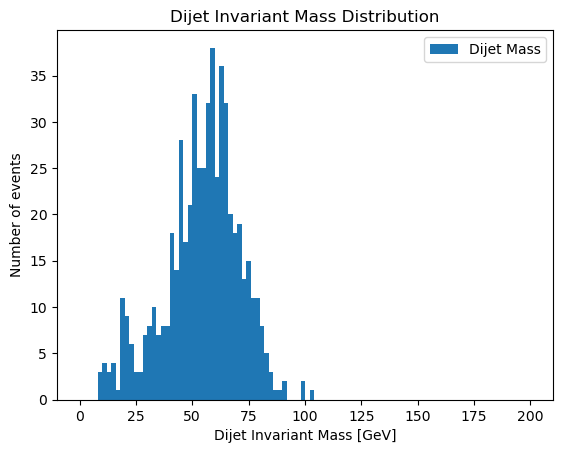

In [103]:
# Plot the dijet invariant mass
plt.hist(dijet_masses, bins=100, range=(0, 200), label='Dijet Mass')
plt.xlabel('Dijet Invariant Mass [GeV]')
plt.ylabel('Number of events')
plt.legend()
plt.title('Dijet Invariant Mass Distribution')
plt.show()